## Check dry static stability

Vertical gradient of potential temperature is a measure of dry static stability. If the potential temperature

$\theta = T(\frac{P_0}{P})^{\frac{R}{c_p}}$

increases with height, then parcels raised adiabatically from their initial height will always be colder and thus denser than their environment and will sink back to their original pressure. If the potential temperature decreases with height, then parcels raised up will be warmer than their environment and will be accelerated upward by buoyancy. Therefore,

if the potential temperature increases with height ($\frac{d\theta}{dz}>0$), the temperature profile is stable,

if the potential temperature decreases with height ($\frac{d\theta}{dz}<0$), the temperature profile is unstable.

From Dennis L. Hartmann, in Global Physical Climatology (Second Edition), 2016: Introduction to the Climate System - 1.6.3 Static Stability and the Adiabatic Lapse Rate (https://www.sciencedirect.com/topics/earth-and-planetary-sciences/potential-temperature)

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.const import init_const
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_constants, path_to_data_umserve, path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
# UM parameters
metallicity = "1x solar"

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

In [6]:
# Calculate potential temperature
pres0 = iris.cube.Cube(2e7, units="Pa").data
vrbls = {}
for planet, planet_const in zip(PLANETS.keys(), PLANET_CONSTS):
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['rose_suite']}.nc"
        temp = iris.load_cube(str(fpath / fname), um.temp)
        pres = iris.load_cube(str(fpath / fname), um.pres)
        cp = planet_const.planet_specific_heat_capacity.data
        Rs = planet_const.planet_specific_gas_constant.data
        M = planet_const.planet_mean_molar_mass_of_air.data
        R = Rs * M
        theta = temp.data * (pres0 / pres.data) ** (R / cp)
        vrbls[planet][exp] = {"theta": theta, "lvls": temp.coord("level_height").points}

In [7]:
lats = temp.coord("latitude").points
lons = temp.coord("longitude").points

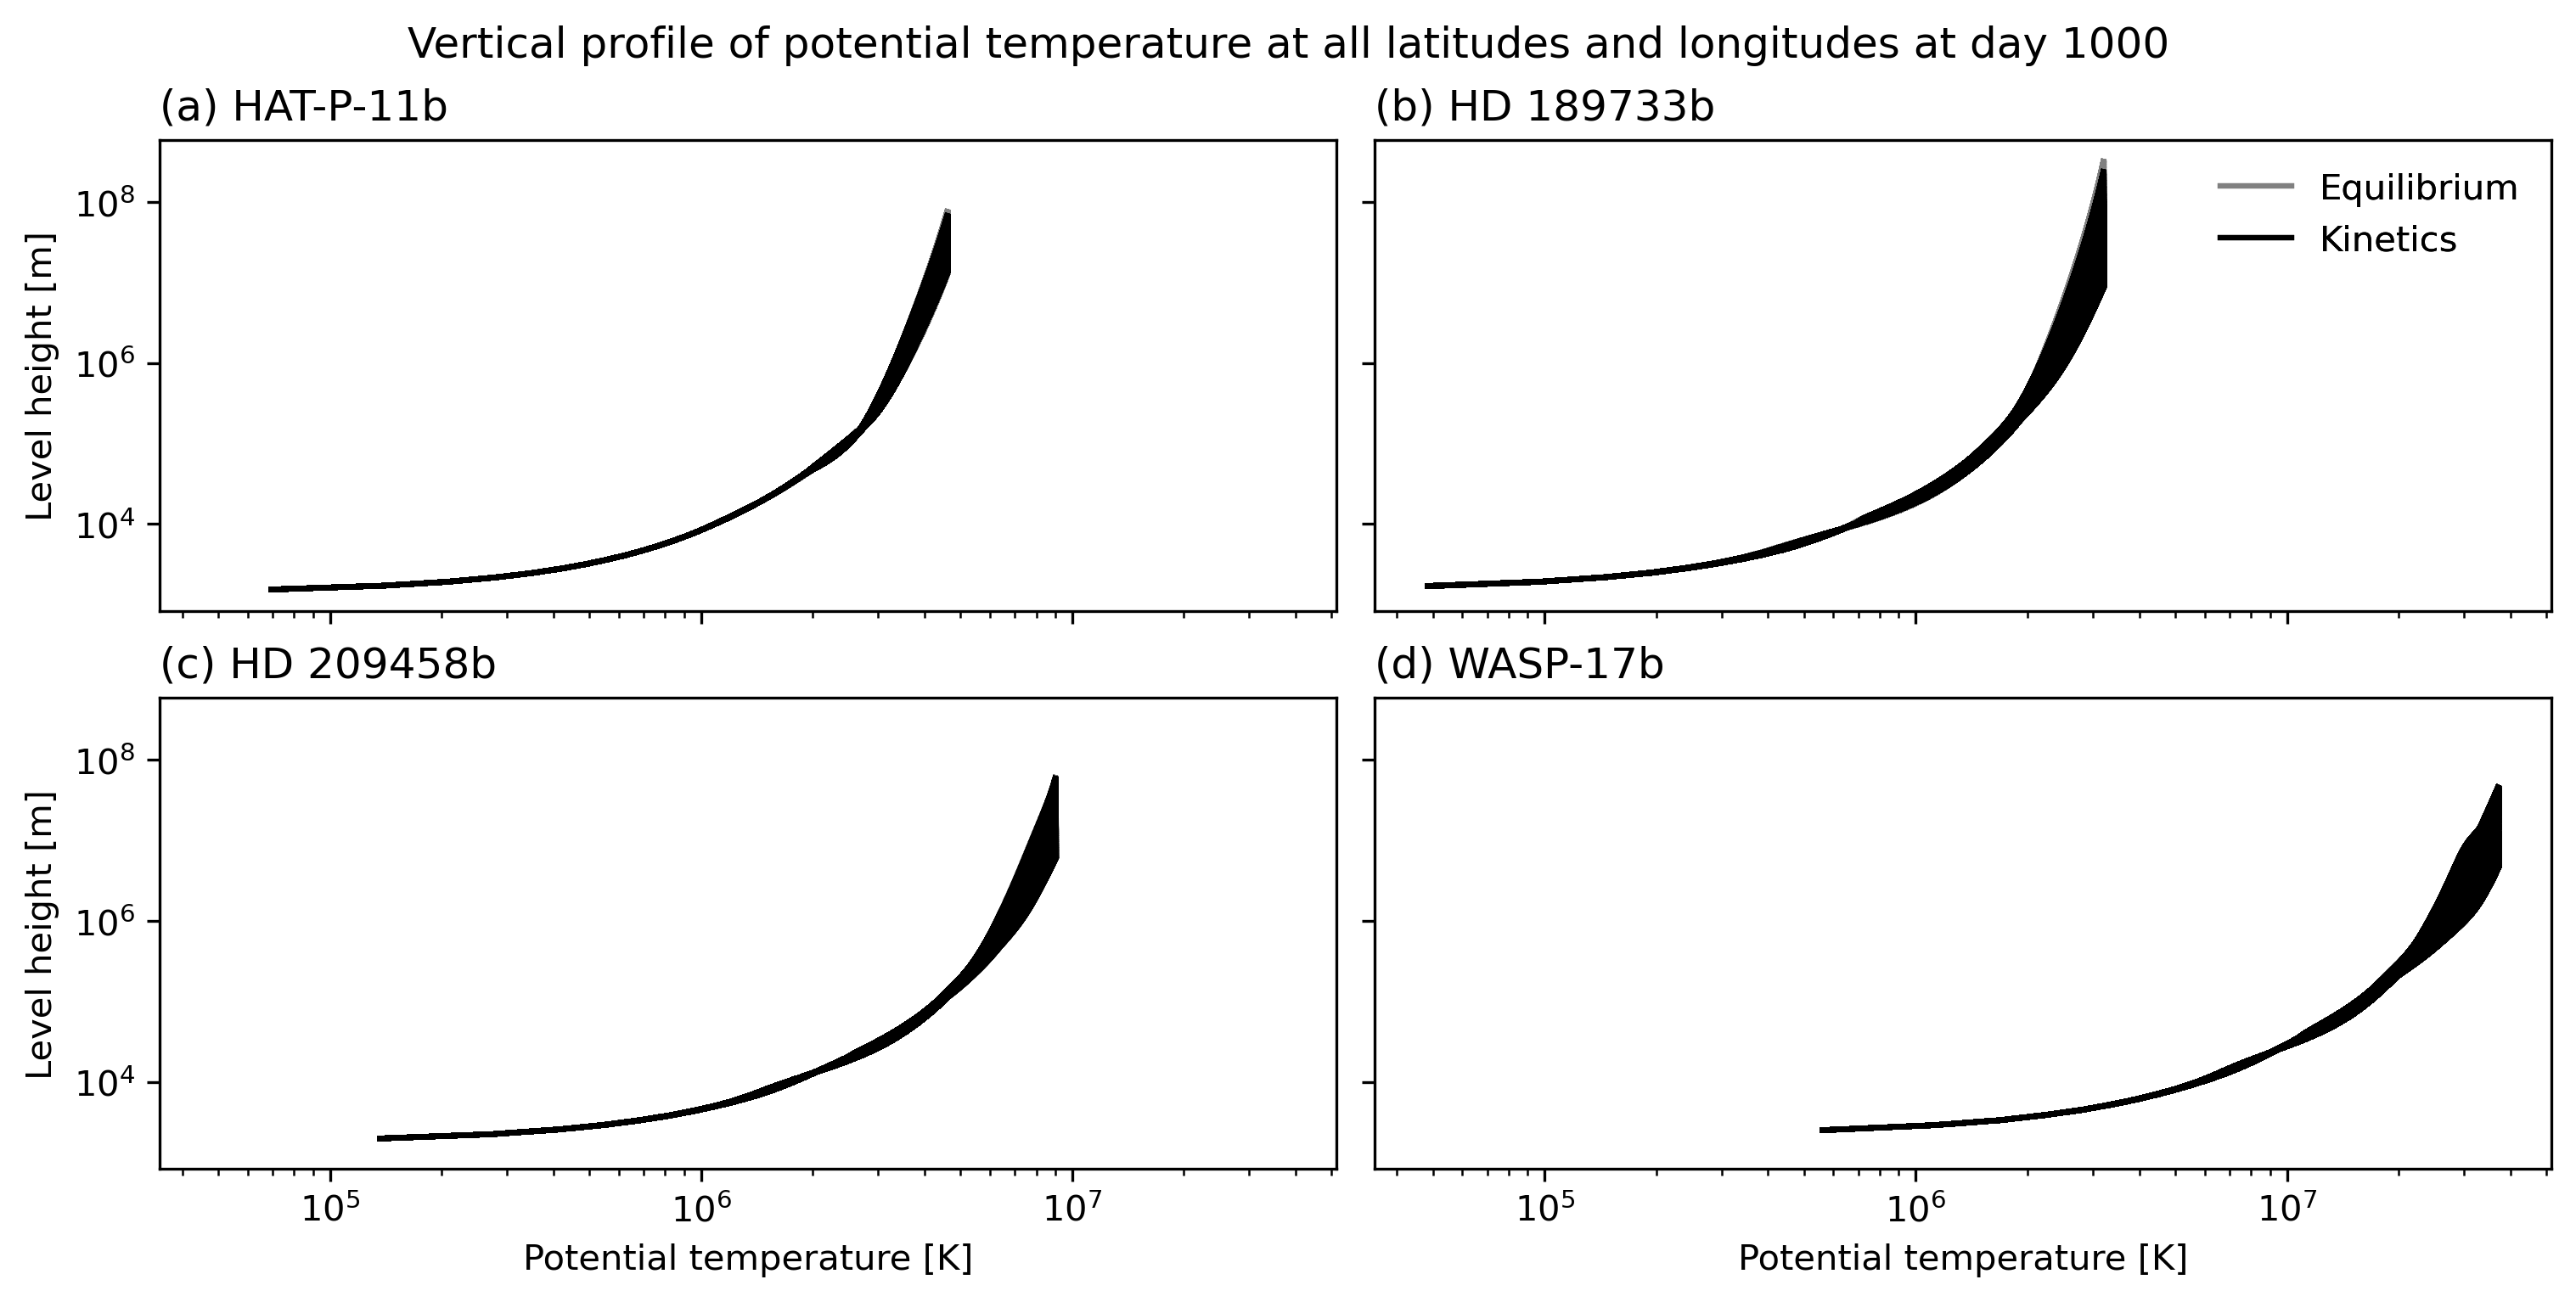

In [8]:
# Plot potential temperature at all grid points
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, clr in zip(["equilibrium", "kinetics"], ["grey", "k"]):
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                iax.plot(
                    vrbls[planet][exp]["lvls"],
                    vrbls[planet][exp]["theta"][-1, :, i, j],
                    color=clr,
                )
    iax.set_xscale("log")
    iax.set_yscale("log")
for iax in ax.flatten():
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Potential temperature [K]")
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("Level height [m]")
add_custom_legend(
    ax[0, 1],
    {
        "equilibrium".capitalize(): {"color": "grey"},
        "kinetics".capitalize(): {"color": "k"},
    },
    frameon=False,
    loc="upper right",
)
fig.suptitle(
    "Vertical profile of potential temperature at all latitudes and longitudes at day 1000"
)
figname = "theta_vp.png"
fig.savefig(path_to_results / "circulation" / figname)

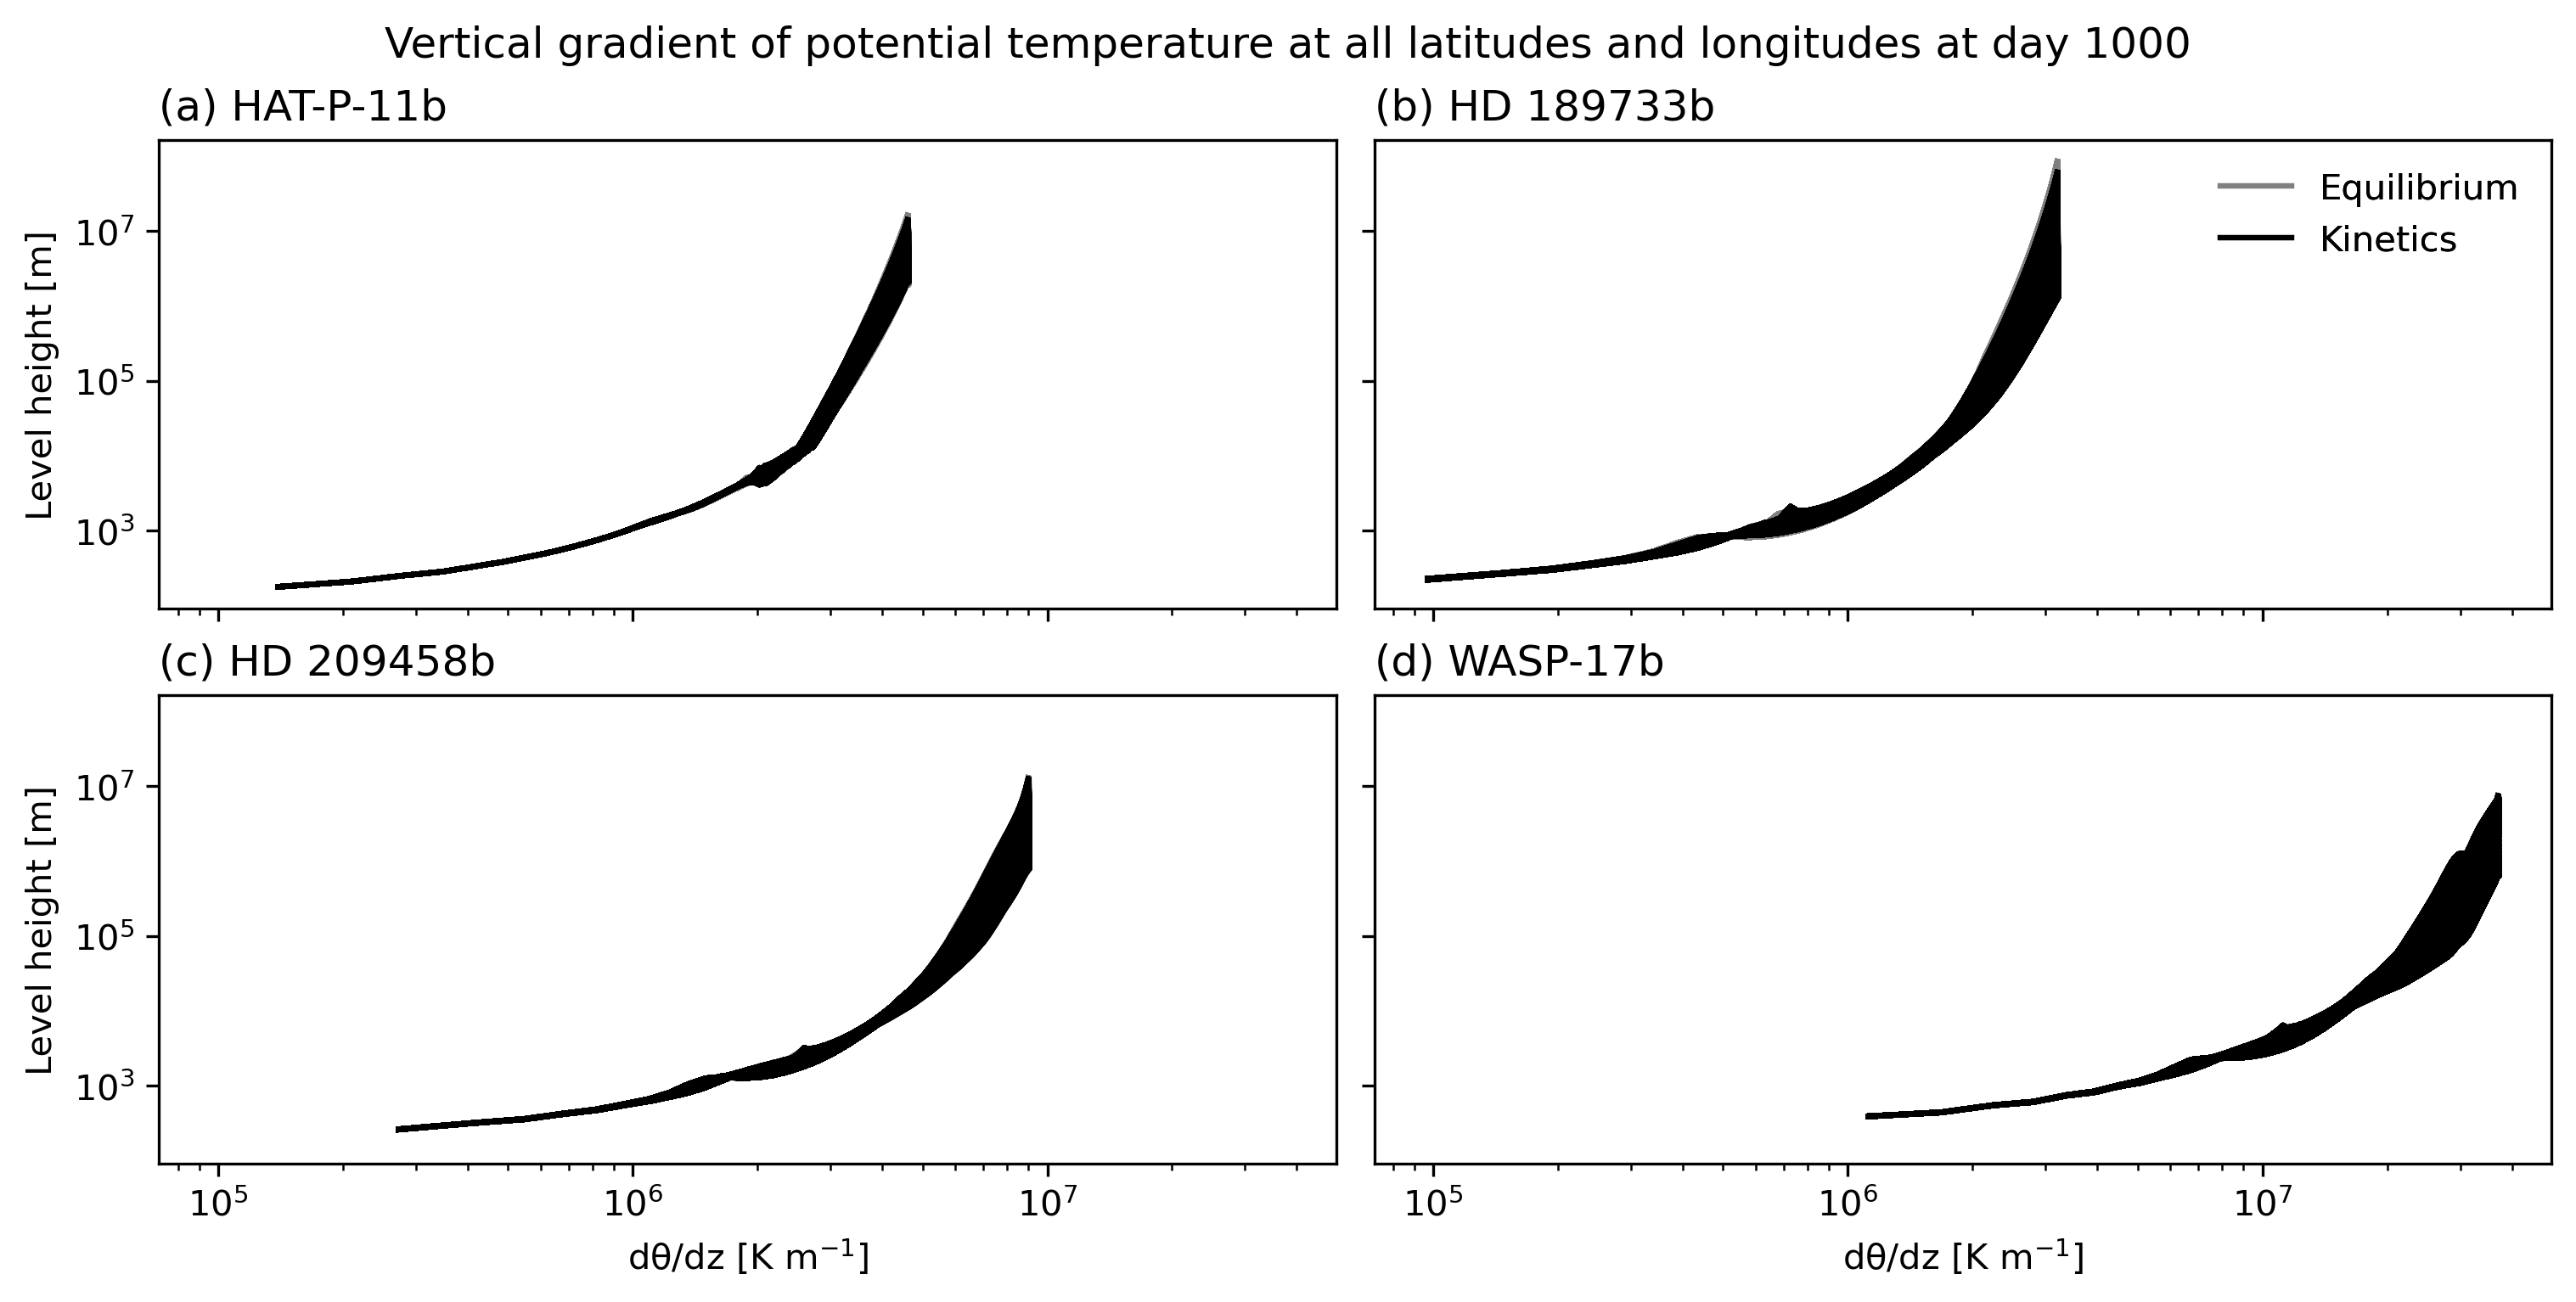

In [9]:
# Plot dtheta/dz at all grid points
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, clr in zip(["equilibrium", "kinetics"], ["grey", "k"]):
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                iax.plot(
                    vrbls[planet][exp]["lvls"][1:],
                    np.diff(vrbls[planet][exp]["theta"][-1, :, i, j]),
                    color=clr,
                )
    iax.set_xscale("log")
    iax.set_yscale("log")
for iax in ax.flatten():
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel(r"d${\theta}$/dz [K $m^{-1}$]")
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("Level height [m]")
add_custom_legend(
    ax[0, 1],
    {
        "equilibrium".capitalize(): {"color": "grey"},
        "kinetics".capitalize(): {"color": "k"},
    },
    frameon=False,
    loc="upper right",
)
fig.suptitle(
    r"Vertical gradient of potential temperature at all latitudes and longitudes at day 1000"
)
figname = "dtheta_dz.png"
fig.savefig(path_to_results / "circulation" / figname)

In [10]:
# Check each grid cell (having no print statements after running this cell is good)
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        for t in np.arange(0, temp.coord("time").points.shape[0] - 1, 1):
            for i, lat in enumerate(lats):
                for j, lon in enumerate(lons):
                    if np.diff(vrbls[planet][exp]["theta"][t, :, i, j]).any() < 0:
                        print(planet, exp, t, i, j)